In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# install OpenCV
!pip install opencv-python

# the usual ...
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.image as mpimg
import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
########################################################################
# Converting image to greyscale
########################################################################

def convert_to_greyscale(color_img):
    grey_img = np.dot(
        color_img[..., :3], 
        [0.299, 0.587, 0.144])
    return grey_img

In [0]:
########################################################################
# Applying blur to the image
########################################################################

def apply_correlation(img, kernel, mode='valid'):
    img = cv2.imread(img, 0)
    img_height, img_width = (img.shape[:2])
    kernel_height, kernel_width = (kernel.shape[:2])

    if img_height < kernel_height or img_width < kernel_width:
        return img

    kernel_mid_x = math.ceil(kernel_width / 2)
    kernel_mid_y = math.ceil(kernel_height / 2)

    image_result = None

    if mode == 'valid':

        new_image_height = img_height - kernel_height - 1
        new_image_width = img_width - kernel_width - 1
        image_result = np.zeros((new_image_height, new_image_width))

        for i in range(kernel_mid_y - 1, img_height - kernel_mid_y + 1):
            for j in range(kernel_mid_x - 1, img_width - kernel_mid_x + 1):
                image_result[i - kernel_mid_y - 1][j - kernel_mid_x - 1] = dot_product(j, i, img_height, img_width,
                                                                                  kernel_height, kernel_width, img, kernel,
                                                                                  mode)

    elif mode == 'same':
        image_result = np.zeros((img_height, img_width))

        for i in range(img_height):
            for j in range(img_width):
                image_result[i - kernel_mid_y - 1][j - kernel_mid_x - 1] = dot_product(j, i, img_height, img_width,
                                                                                  kernel_height, kernel_width, img, kernel,
                                                                                  mode)

    elif mode == 'full':
        image_result = np.zeros((img_height + kernel_height - 1, img_width + kernel_width - 1))

        for i in range(img_height):
            for j in range(img_width):
                image_result[i - kernel_mid_y - 1][j - kernel_mid_x - 1] = dot_product(j, i, img_height, img_width,
                                                                                  kernel_height, kernel_width, img, kernel,
                                                                                  mode)

    return image_result


def dot_product(img_x, img_y, img_height, img_width, kernel_height, kernel_width, img, kernel, mode):
    kernel_mid_x = math.ceil(kernel_width / 2)
    kernel_mid_y = math.ceil(kernel_height / 2)
    my_sum = 0

    if mode == 'valid':
        for i in range(math.ceil(-kernel_height / 2), math.ceil(kernel_height / 2)):
            for j in range(math.ceil(-kernel_width / 2), math.ceil(kernel_width / 2)):
                my_sum += img[img_y + i][img_x + j] * kernel[kernel_mid_y - 1 + i][kernel_mid_x - 1 + j]

    elif mode == 'same':
        for i in range(math.ceil(-kernel_height / 2), math.ceil(kernel_height / 2)):
            for j in range(math.ceil(-kernel_width / 2), math.ceil(kernel_width / 2)):
                if (((img_x + j) < img_width and (img_x + j) >= 0 and (img_y + i) < img_height and (img_y + i) >= 0)):
                    my_sum += img[img_y + i][img_x + j] * kernel[kernel_mid_y - 1 + i][kernel_mid_x - 1 + j]

    elif mode == 'full':
        for i in range(math.ceil(-kernel_height / 2), math.ceil(kernel_height / 2)):
            for j in range(math.ceil(-kernel_width / 2), math.ceil(kernel_width / 2)):
                if ((img_y + i) < img_height and (img_y + i) >= 0) and ((img_x + j) < img_width and (img_x + j) >= 0):
                    my_sum += img[img_y + i][img_x + j] * kernel[kernel_mid_y - 1 + i][kernel_mid_x - 1 + j]

    return my_sum


def apply_convolution(img, kernel, mode='valid'):
    new_kernel = np.fliplr(np.flipud(kernel))
    return apply_correlation(img, new_kernel, mode)

In [0]:
########################################################################
# Histogram Equalization 
# https://www.researchgate.net/publication/283727396_Image_enhancement_by_Histogram_equalization
########################################################################

def apply_histogram_equalization(img):
    new_img = img.copy().flatten()
    hist_result = np.histogram(new_img, 256, density=True)
    cdf = 255 * hist_result[0].cumsum() / hist_result[0].cumsum()[-1]
    equalized_img = np.interp(new_img, hist_result[1][:-1], cdf).reshape(img.shape)
    return equalized_img

In [0]:
########################################################################
# Bilateral Filter
# https://www.cs.jhu.edu/~misha/ReadingSeminar/Papers/Tomasi98.pdf
# https://pdfs.semanticscholar.org/3796/3f1672c4f53f57a1774c381aaf86695f2087.pdf
########################################################################


def bilateral_filter(orgn, filtered_img, x, y, d, i_sigma, s_sigma):

    Wp = 0
    i_filter = 0

    for i in range(d):
        for j in range(d):
            x_neigh = int(x - (d / 2 - i))
            y_neigh = int(y - (d / 2 - j))

            x_len = len(orgn)
            y_len = len(orgn[0])

            if x_neigh >= x_len:
                x_neigh -= x_len
            if y_neigh >= y_len:
                y_neigh -= y_len

            gi = (1.0 / (2 * math.pi * (i_sigma ** 2))) \
                 * math.exp(- (orgn[x_neigh][y_neigh] - orgn[x][y] ** 2) / (2 * i_sigma ** 2))
            gs = (1.0 / (2 * math.pi * (s_sigma ** 2))) \
                 * math.exp(- (np.sqrt((x_neigh - x)**2 + (y_neigh - y)**2) ** 2) / (2 * s_sigma ** 2))

            i_filter += orgn[x_neigh][y_neigh] * (gi * gs)
            Wp = Wp + (gi * gs)

    new = int(round(i_filter / Wp))
    filtered_img[x][y] = new


def apply_bilateral_filter(img, d, i_sigma, s_sigma):
    filtered_image = np.zeros(img.shape)

    for i in range(len(img)):
        for j in range(len(img[0])):
            bilateral_filter(img, filtered_image, i, j, d, i_sigma, s_sigma)

    return filtered_image


In [0]:
########################################################################
# Thresholding
# https://www.researchgate.net/publication/220494200_Adaptive_Thresholding_using_the_Integral_Image
########################################################################

def apply_threshold(img, s, T = 0.15):
    result_img = np.zeros(img.shape)
    img_height = img.shape[0]
    img_width = img.shape[1]

    for i in range(img_height):
        y1 = i - int(int(max(img_height, img_width) / 8) / 4)
        y2 = i + int(int(max(img_height, img_width) / 8) / 4)

        if y1 < 0:
            y1 = 0
        if y2 >= img_height:
            y2 = img_height - 1

        for j in range(img_width):
            x1 = j - int(int(max(img_height, img_width) / 8) / 4)
            x2 = j + int(int(max(img_height, img_width) / 8) / 4)

            if x1 < 0:
                x1 = 0
            if x2 >= img_width:
                x2 = img_width - 1
            count = (x2 - x1) * (y2 - y1)

            V = ((s[y2][x2]-s[y2][x1]-s[y1][x2]+s[y1][x1]) * (1.0 - T))
            
            if (int)(img[i][j][0] * count) < (int)(V[0]):
                result_img[i][j] = 0
            else:
                result_img[i][j] = 255
    return result_img


In [0]:
########################################################################
# Skew Detection
# https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
########################################################################

def apply_skew_detection(img):
    image = cv2.imread(img)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    inverted_image = cv2.bitwise_not(gray_image)

    image_threshold = cv2.threshold(inverted_image, 0, 255,
                           cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    skew_angle = cv2.minAreaRect(np.column_stack(np.where(image_threshold > 0)))[-1]

    if skew_angle >= -45:
        skew_angle = -skew_angle
    else:
        skew_angle = -(90 + skew_angle)

    # de-skew the image
    (height, width) = image.shape[:2]
    rotated = cv2.warpAffine(image, 
                             cv2.getRotationMatrix2D((width // 2, height // 2), skew_angle, 1.0), 
                             (width, height),
                             flags=cv2.INTER_CUBIC, 
                             borderMode=cv2.BORDER_REPLICATE)

    return rotated


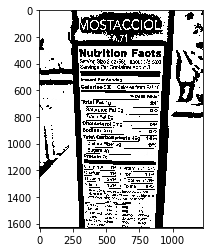

In [0]:
########################################################################
# PRE-PROCESS THE IMAGE
########################################################################

def pre_process_img(image_path):
    img = cv2.imread(image_path)

    img = convert_to_greyscale(img)
    cv2.imwrite('/content/drive/My Drive/grey_img.jpg', img)

    img = apply_convolution('/content/drive/My Drive/grey_img.jpg', cv2.getGaussianKernel(3, 3), 'same')
    cv2.imwrite('/content/drive/My Drive/blur_img.jpg', img)

    img = cv2.imread('/content/drive/My Drive/blur_img.jpg', cv2.IMREAD_GRAYSCALE)
    img = apply_histogram_equalization(img)
    cv2.imwrite('/content/drive/My Drive/equalized.jpg', img)

    new_img = apply_bilateral_filter(img, 8, 14.0, 18.0)
    cv2.imwrite('/content/drive/My Drive/bilateral_filtered.jpg', img)

    img = cv2.imread('/content/drive/My Drive/bilateral_filtered.jpg')
    thresh = apply_threshold(img, cv2.integral(img))
    cv2.imwrite('/content/drive/My Drive/threshold.jpg', thresh)

    img = apply_skew_detection('/content/drive/My Drive/threshold.jpg')
    cv2.imwrite('/content/drive/My Drive/final_img.jpg', img)

    return img


img_path = '/content/drive/My Drive/img3.jpeg'
processed_img = pre_process_img(img_path)
plt.imshow(processed_img, cmap = plt.get_cmap('gray'))
plt.show()